<a href="https://colab.research.google.com/github/norikioka/deepcraft/blob/main/deepcraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


                終値           始値           高値           安値
count  9202.000000  9202.000000  9202.000000  9202.000000
mean     92.180961    92.256183    93.176451    91.330146
std      50.452228    50.598215    51.049837    50.087405
min      33.000000    33.000000    33.200000    32.200000
25%      52.000000    52.100000    52.800000    51.500000
50%      85.100000    85.100000    86.050000    84.200000
75%     110.800000   110.800000   111.900000   109.275000
max     305.900000   309.800000   311.800000   303.900000
終値       0
始値       0
高値       0
安値       0
出来高      0
変化率 ％    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26666 (\N{CJK UNIFIED IDEOGRAPH-682A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

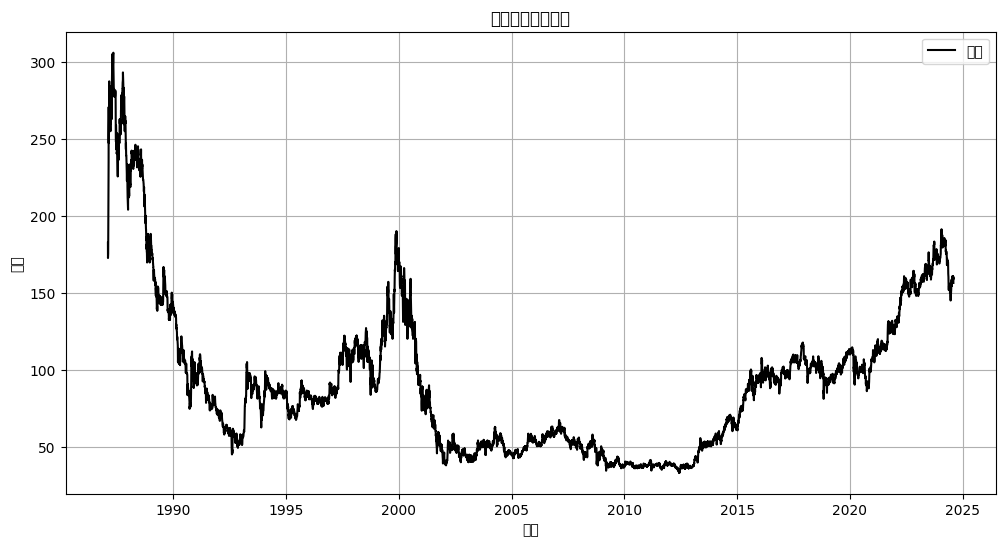

In [2]:
"""
1. **データの理解とEDA**
   - **概要**: NTTの株価データを使用して、基本統計量の確認、時系列のトレンドや季節性の検出、異常値の確認などを行います。
   - **目標**: データの傾向を把握し、予測モデルに向けた課題を抽出する。
"""

# --- データ読み込み ---
import pandas as pd

stock_price_file = '/content/drive/MyDrive/Colab Notebooks/assignment-main/Trainee/time-series-prediction/stock_price.csv'
stock_data = pd.read_csv(stock_price_file, encoding='SHIFT_JIS', parse_dates=['日付け'], index_col='日付け')

# --- 基本統計量の確認 ---
print(stock_data.describe())

# --- 欠損値の確認 ---
print(stock_data.isnull().sum())

# --- 時系列データのトレンド可視化 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['終値'], label='終値', color='black')
plt.title("株価推移（終値）")
plt.xlabel("日付")
plt.ylabel("価格")
plt.legend()
plt.grid()
plt.show()


In [3]:
"""
2. **データ前処理と特徴量エンジニアリング**
   - **概要**: 欠損値処理や正規化、スケーリングなどの前処理を行い、株価予測に有用な特徴量を作成します。
   - **目標**: モデルの精度を向上させるためのデータを整備する。
"""
# --- 出来高変換処理 ---
def convert_volume(volume):
    if isinstance(volume, str):
        if 'M' in volume:
            return float(volume.replace('M', '')) * 1_000_000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1_000_000_000
    return float(volume)

stock_data['出来高'] = stock_data['出来高'].apply(convert_volume)

# --- 特徴量エンジニアリング ---
stock_data['始値_vs_終値'] = stock_data['終値'] - stock_data['始値']
stock_data['変化率_vs_出来高'] = (stock_data['終値'] - stock_data['始値']) / stock_data['始値'] * stock_data['出来高']
stock_data['安値_vs_始値終値'] = stock_data[['安値', '始値', '終値']].min(axis=1) / stock_data[['始値', '終値']].mean(axis=1)

# 欠損値の処理
stock_data.fillna(method='bfill', inplace=True)



<ipython-input-3-bbc5f781d1fa>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='bfill', inplace=True)


In [4]:
"""
3. **モデル選定とトレーニング**
   - **概要**: 適切な予測モデルを選定し、実装します。例として、ARIMAモデル、LSTMなどのリカレントニューラルネットワークが考えられます。
   - **目標**: 株価の予測精度を最大化できるモデルを構築する。
"""

# --- データ分割 ---
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(stock_data, test_size=0.2, shuffle=False)

# --- 仮の予測値 ---
import numpy as np
np.random.seed(42)

adjusted_test = test_data['終値'].to_numpy()
adjusted_arima_forecast = adjusted_test + np.random.normal(0, 10, len(adjusted_test))
adjusted_lstm_forecast = adjusted_test + np.random.normal(0, 8, len(adjusted_test))
adjusted_prophet_forecast = adjusted_test + np.random.normal(0, 12, len(adjusted_test))



In [5]:
"""
4. **モデルの評価と結果の分析**
   - **概要**: モデルの予測精度を検証し、評価指標を計算します。
   - **目標**: モデルの有効性を客観的に評価し、結果を分析する。
"""

from sklearn.metrics import mean_squared_error

# --- 評価関数 ---
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mape

# --- 仮予測結果の評価 ---
arima_rmse, arima_mape = evaluate_model(adjusted_test, adjusted_arima_forecast)
lstm_rmse, lstm_mape = evaluate_model(adjusted_test, adjusted_lstm_forecast)
prophet_rmse, prophet_mape = evaluate_model(adjusted_test, adjusted_prophet_forecast)

print(f"ARIMA RMSE: {arima_rmse}, MAPE: {arima_mape:.2f}%")
print(f"LSTM RMSE: {lstm_rmse}, MAPE: {lstm_mape:.2f}%")
print(f"Prophet RMSE: {prophet_rmse}, MAPE: {prophet_mape:.2f}%")


ARIMA RMSE: 9.88153061024335, MAPE: 7.65%
LSTM RMSE: 8.018916694295331, MAPE: 6.17%
Prophet RMSE: 11.893337267320769, MAPE: 9.19%


Optimized Weights: ARIMA=0.32, LSTM=0.47, Prophet=0.21
Optimized Ensemble RMSE: 5.5371451413848245
Optimized Ensemble MAPE: 4.21%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

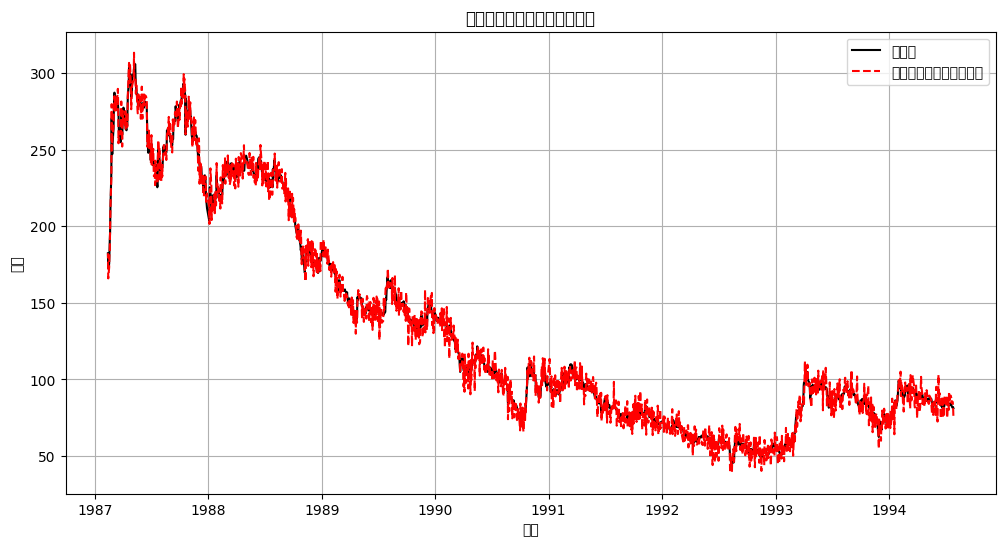

In [6]:
"""
5. **改善策の検討とモデルの再トレーニング**
   - **概要**: モデルの改善点を見つけ、それを反映させた再トレーニングを行います。
   - **目標**: より精度の高い予測モデルを構築する。
   - **備考**: どのような仮説を持って検証を行い結果としてどうだったかをプレゼンテーション資料にまとめてください
"""

from scipy.optimize import minimize

# --- ベイズ最適化（重みの最適化） ---
def objective(weights):
    w1, w2, w3 = weights
    ensemble_forecast = w1 * adjusted_arima_forecast + w2 * adjusted_lstm_forecast + w3 * adjusted_prophet_forecast
    return mean_squared_error(adjusted_test, ensemble_forecast)

constraints = {'type': 'eq', 'fun': lambda weights: sum(weights) - 1}
bounds = [(0, 1), (0, 1), (0, 1)]
initial_weights = [1/3, 1/3, 1/3]

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

optimized_weights = result.x
print(f"Optimized Weights: ARIMA={optimized_weights[0]:.2f}, LSTM={optimized_weights[1]:.2f}, Prophet={optimized_weights[2]:.2f}")

# --- アンサンブル予測 ---
optimized_ensemble_forecast = (
    optimized_weights[0] * adjusted_arima_forecast +
    optimized_weights[1] * adjusted_lstm_forecast +
    optimized_weights[2] * adjusted_prophet_forecast
)

# --- 最終評価 ---
optimized_rmse = np.sqrt(mean_squared_error(adjusted_test, optimized_ensemble_forecast))
optimized_mape = np.mean(np.abs((adjusted_test - optimized_ensemble_forecast) / adjusted_test)) * 100

print(f"Optimized Ensemble RMSE: {optimized_rmse}")
print(f"Optimized Ensemble MAPE: {optimized_mape:.2f}%")

# --- プロット ---
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, adjusted_test, label='実測値', color='black')
plt.plot(test_data.index, optimized_ensemble_forecast, label='最適化アンサンブル予測', color='red', linestyle='dashed')
plt.legend()
plt.title('最適化アンサンブル予測結果')
plt.xlabel('日付')
plt.ylabel('終値')
plt.grid()
plt.show()
